In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import torch
from torch import nn
import torch.nn.functional as F
import  torch.optim as optim
from    matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font',family='Times New Roman', size=16)

In [3]:
device

device(type='cuda')

In [4]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [5]:
def get_data():
    dataset_conc=[]
    path=r'Dataset'
    all_files=glob.glob(path+"/*.csv")
    for filename in all_files:
        df=pd.read_csv(filename,index_col=None,header=0)
        #将数据中value为0的替换成NaN
        df=df.replace(0,np.nan)
        #处理value那层数据，将0去除掉
        df=df.dropna(axis=0, how='any',subset=['value'])
        df.value = preprocessing.normalize([df.value]).T
        dataset_conc.append(convert_2d(df))
    frame=pd.concat(dataset_conc,axis=0,ignore_index=True)
    y = frame.iloc[:, 60]
    X = frame.iloc[:, 0:60]
    X_train = X[:int(X.shape[0] * 0.7)]
    X_test = X[int(X.shape[0] * 0.7):]
    y_train = y[:int(X.shape[0] * 0.7)]
    y_test = y[int(X.shape[0] * 0.7):]


    X_train = X_train.to_numpy()
    nrows, ncols = X_train.shape
    X_train = X_train.reshape(nrows, ncols, 1)

    X_test = X_test.to_numpy()
    nrows, ncols = X_test.shape
    X_test = X_test.reshape(nrows, ncols, 1)

    y_test = y_test.to_numpy()
    # print("X_train:",X_train.shape)
    #[62107,60,1]
    # print("y_train:",y_train.shape)
    #[62107,]
    return X_train,y_train,X_test,y_test

In [6]:
X_train,y_train,X_test,y_test=get_data()

In [7]:
# 定义实现因果卷积的类
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 定义了一个残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # n_inputs:输入通道数
        # n_outputs:输出通道数
        # stride：步长
        # padding:填充长度
        # dilation：扩张率
        # 定义第一个空洞卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 根据第一个卷积层的输出与padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        # 添加激活函数与dropout正则化方法完成第一个卷积
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 堆叠同样结构的第二个卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 将卷积模块的所有组建通过Sequential方法依次堆叠在一起
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 如果输出纬度和输入维度不一致，则必须对输出进行1X1卷积
        # 如果通道数不一样，那么需要对输入x做一个逐元素的一维卷积以使得它的纬度与前面两个卷积相等。
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        # 不同激活函数的尝试
        # self.sigmod = nn.Softmax()
        # self.tanh = nn.Tanh()
        # self.softPlus = nn.Softplus()
        # self.leaky = nn.LeakyReLU()
        self.init_weights()

    # 初始化为从均值为0，标准差为0.01的正态分布中采样的随机值
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    # 结合卷积与输入的恒等映射（或输入的逐元素卷积），并投入ReLU 激活函数完成残差模块
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# 时间卷积网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.5):
        super(TemporalConvNet, self).__init__()
        # num_input:输入特征数，默认为1
        # num_levels:网络层数，每一层是一个残差块
        # num_channels:储存了所有层级的输出通道数
        layers = []
        # num_channels为各层卷积运算的输出通道数或卷积核数量
        num_levels = len(num_channels)
        # 空洞卷积的扩张系数若随着网络层级的增加而成指数级增加，则可以增大感受野并不丢弃任何输入序列的元素
        # dilation_size根据层级数成指数增加，并从num_channels中抽取每一个残差模块的输入通道数与输出通道数
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # 将所有残差模块堆叠起来组成一个深度卷积网络
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x=self.network(x)
        #print('tcn_shape:',x.shape)
        return x

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            #[512,64,15]
        )
        self.bilstm=nn.LSTM(input_size=960, hidden_size=64, num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )
    def attention_net(self, lstm_output, final_state):
        batch_size = len(lstm_output)
        hidden = final_state.view(batch_size, -1,
                                  1)  # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)  # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)

        # context : [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,15*64)
        #[512,1,960]
        out,(final_hidden_state,final_cell_state) = self.bilstm(out)
        attn_out,attention=self.attention_net(out,final_hidden_state)
        #[512,128]
        out=self.fc(attn_out)
        #[512,2]
        return out

In [9]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            #[512,64,15]
        )
        self.bigru=nn.GRU(input_size=960, hidden_size=64, num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )
    def attention_net(self, lstm_output, final_state):
        batch_size = len(lstm_output)
        hidden = final_state.view(batch_size, -1,
                                  1)  # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)  # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)

        # context : [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,15*64)
        #[512,1,960]
        out,final_hidden_state=self.bigru(out)
        attn_out,attention=self.attention_net(out,final_hidden_state)
        #[512,128]
        out=self.fc(attn_out)
        #[512,2]
        return out

In [10]:
loss_list=[]
epoch_list=[]
acc_list=[]
ans_acc_list=[]
train_acc_list=[]

In [11]:
loss_list2=[]
epoch_list2=[]
acc_list2=[]
ans_acc_list2=[]
train_acc_list2=[]

In [12]:
import torch.utils.data as Data
from numpy import *
def train(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.train()

    for epoch in range(501):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list.append(acc)
        ans_acc_list.append(acc)
        train_acc_list.append(train_acc)
        loss_list.append(loss.item())
        epoch_list.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list),4))
            acc_list.clear()
    torch.save(net.state_dict(),'model/net_bilstm_attention_params.pth')
    plt.plot(epoch_list,loss_list,color='red',label='training Loss')
    plt.plot(epoch_list,ans_acc_list,color='green',label='test Acc')
    plt.plot(epoch_list,train_acc_list,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [13]:
import torch.utils.data as Data
from numpy import *
def train2(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net2()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.train()

    for epoch in range(501):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list2.append(acc)
        ans_acc_list2.append(acc)
        train_acc_list2.append(train_acc)
        loss_list2.append(loss.item())
        epoch_list2.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list2),4))
            acc_list2.clear()
    torch.save(net.state_dict(),'model/net_bigru_attention_params.pth')
    plt.plot(epoch_list2,loss_list2,color='red',label='training Loss')
    plt.plot(epoch_list2,ans_acc_list2,color='green',label='test Acc')
    plt.plot(epoch_list2,train_acc_list2,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [14]:
def test(model,x_test,y_test,flag):
    model.eval()
    torch_dataset=Data.TensorDataset(x_test,y_test)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    acc = 0.0
    count = 0
    ans_labels=[]
    ans_pre=[]
    for index, data in enumerate(loader):
        inputs, labels = data  # 5,3,400,600  5,10
        count += len(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        acc += (labels == predict).sum().item()
        ans_labels+=labels.cpu().numpy().tolist()
        ans_pre+=predict.cpu().numpy().tolist()
    #evaluate performance
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    if flag==True:
      Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
      Accuracy = accuracy_score(ans_labels, ans_pre)
      precision = precision_score(ans_labels, ans_pre, average='binary')
      recall = recall_score(ans_labels, ans_pre, average='binary')
      F1_Score = f1_score(ans_labels, ans_pre, average='binary')
      print("Confusion_Matrix")
      print(Confusion_Matrix)
      print("Accuracy ", Accuracy)
      print("Precision ", precision)
      print("recall ", recall)
      print("f1_score ", F1_Score)
    return round(acc/count,4)

In [15]:
new_y_train=y_train
new_y_train=torch.tensor(new_y_train)
new_x_train=X_train
new_input=torch.tensor(new_x_train).permute(0,2,1).to(torch.float32)
y_train=F.one_hot(torch.tensor(y_train).to(torch.int64),2)
y_train=y_train.to(torch.float32)
#[batch_size,seq_len,embedding_size]=>[batch_size,embeding_size,seq_len]
input=torch.tensor(X_train).permute(0,2,1).to(torch.float32)
X_test = torch.tensor(X_test).permute(0, 2, 1).to(torch.float32)
y_test=torch.tensor(y_test)

In [16]:
# model=train(input,y_train,X_test,y_test,new_input,new_y_train)

D:\me_soft\Anaconda\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[23986     0]
 [ 2632     0]]
Accuracy  0.9011195431662784
Precision  0.0
recall  0.0
f1_score  0.0


D:\me_soft\Anaconda\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[56266     0]
 [ 5841     0]]
Accuracy  0.9059526301383097
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.31816190481185913 train_acc 0.906 test_acc： 0.9011
acc平均值： 0.9011
epoch 1 : 0.21388037502765656 train_acc 0.906 test_acc： 0.9011
epoch 2 : 0.39159148931503296 train_acc 0.906 test_acc： 0.9011
epoch 3 : 0.28902119398117065 train_acc 0.906 test_acc： 0.9011
epoch 4 : 0.3162464201450348 train_acc 0.906 test_acc： 0.9011
epoch 5 : 0.26062121987342834 train_acc 0.906 test_acc： 0.9011
epoch 6 : 0.23373855650424957 train_acc 0.906 test_acc： 0.9011
epoch 7 : 0.2442760318517685 train_acc 0.906 test_acc： 0.9011
epoch 8 : 0.3885844051837921 train_acc 0.9109 test_acc： 0.8963
epoch 9 : 0.28129395842552185 train_acc 0.9186 test_acc： 0.9045
epoch 10 : 0.2331588715314865 train_acc 0.9246 test_acc： 0.9115
epoch 11 : 0.2671397924423218 train_acc 0.9275 test_acc： 0.9148
epoch 12 : 0.16613240540027618 train_acc 0.9279 test_acc： 0.9163
epoch 13 : 0.22834676504135132 train_acc 0.92

epoch 110 : 0.13595806062221527 train_acc 0.9427 test_acc： 0.9198
epoch 111 : 0.15211333334445953 train_acc 0.9434 test_acc： 0.9228
epoch 112 : 0.2609144151210785 train_acc 0.9432 test_acc： 0.9172
epoch 113 : 0.22239753603935242 train_acc 0.9436 test_acc： 0.9173
epoch 114 : 0.17090456187725067 train_acc 0.9434 test_acc： 0.9177
epoch 115 : 0.10066105425357819 train_acc 0.9439 test_acc： 0.9192
epoch 116 : 0.11142092198133469 train_acc 0.9437 test_acc： 0.9186
epoch 117 : 0.13079144060611725 train_acc 0.9442 test_acc： 0.9168
epoch 118 : 0.22935202717781067 train_acc 0.9443 test_acc： 0.9195
epoch 119 : 0.24015448987483978 train_acc 0.944 test_acc： 0.9206
Confusion_Matrix
[[23556   430]
 [ 1804   828]]
Accuracy  0.9160718310917424
Precision  0.6581875993640699
recall  0.31458966565349544
f1_score  0.42570694087403593
Confusion_Matrix
[[56179    87]
 [ 3329  2512]]
Accuracy  0.944998148356868
Precision  0.96652558676414
recall  0.4300633453175826
f1_score  0.5952606635071089
epoch 120 : 0.245

epoch 216 : 0.17927095293998718 train_acc 0.9642 test_acc： 0.9173
epoch 217 : 0.1466895043849945 train_acc 0.9655 test_acc： 0.9179
epoch 218 : 0.03800185024738312 train_acc 0.9642 test_acc： 0.9213
epoch 219 : 0.1052933931350708 train_acc 0.9663 test_acc： 0.9192
epoch 220 : 0.12169744074344635 train_acc 0.9654 test_acc： 0.9193
epoch 221 : 0.08604512363672256 train_acc 0.9678 test_acc： 0.9181
epoch 222 : 0.14330795407295227 train_acc 0.9688 test_acc： 0.913
epoch 223 : 0.15961140394210815 train_acc 0.9665 test_acc： 0.9248
epoch 224 : 0.08983651548624039 train_acc 0.9664 test_acc： 0.9249
epoch 225 : 0.10251535475254059 train_acc 0.9707 test_acc： 0.919
epoch 226 : 0.16034241020679474 train_acc 0.9663 test_acc： 0.9261
epoch 227 : 0.1359773427248001 train_acc 0.9622 test_acc： 0.9299
epoch 228 : 0.1711195707321167 train_acc 0.9693 test_acc： 0.9251
epoch 229 : 0.0817619040608406 train_acc 0.9716 test_acc： 0.9241
epoch 230 : 0.07048703730106354 train_acc 0.968 test_acc： 0.9294
epoch 231 : 0.0643

epoch 326 : 0.11560090631246567 train_acc 0.9869 test_acc： 0.9449
epoch 327 : 0.06592278182506561 train_acc 0.9849 test_acc： 0.9467
epoch 328 : 0.062174826860427856 train_acc 0.9864 test_acc： 0.9243
epoch 329 : 0.0730501189827919 train_acc 0.9876 test_acc： 0.9391
Confusion_Matrix
[[23458   528]
 [  995  1637]]
Accuracy  0.9427830791193929
Precision  0.7561200923787529
recall  0.6219604863221885
f1_score  0.6825099020220972
Confusion_Matrix
[[56159   107]
 [  786  5055]]
Accuracy  0.9856215885487948
Precision  0.9792716001549787
recall  0.8654340010272213
f1_score  0.9188403162773788
epoch 330 : 0.03785955533385277 train_acc 0.9856 test_acc： 0.9428
epoch 331 : 0.07248178124427795 train_acc 0.9842 test_acc： 0.9466
epoch 332 : 0.06358465552330017 train_acc 0.986 test_acc： 0.9457
epoch 333 : 0.009025424718856812 train_acc 0.9877 test_acc： 0.9412
epoch 334 : 0.07094123214483261 train_acc 0.9859 test_acc： 0.9459
epoch 335 : 0.041040316224098206 train_acc 0.9878 test_acc： 0.9448
epoch 336 : 0

epoch 431 : 0.05042140185832977 train_acc 0.9917 test_acc： 0.9456
epoch 432 : 0.006950704380869865 train_acc 0.9921 test_acc： 0.9413
epoch 433 : 0.01855287328362465 train_acc 0.9891 test_acc： 0.9417
epoch 434 : 0.008899816311895847 train_acc 0.9905 test_acc： 0.9454
epoch 435 : 0.07244972139596939 train_acc 0.9906 test_acc： 0.9411
epoch 436 : 0.03556610271334648 train_acc 0.9902 test_acc： 0.9467
epoch 437 : 0.05125459283590317 train_acc 0.9925 test_acc： 0.943
epoch 438 : 0.03280867636203766 train_acc 0.988 test_acc： 0.9383
epoch 439 : 0.02680678851902485 train_acc 0.9907 test_acc： 0.9434
epoch 440 : 0.03160420060157776 train_acc 0.9913 test_acc： 0.9452
epoch 441 : 0.031706150621175766 train_acc 0.9907 test_acc： 0.9424
epoch 442 : 0.013002816587686539 train_acc 0.9885 test_acc： 0.931
epoch 443 : 0.04866974800825119 train_acc 0.9923 test_acc： 0.9491
epoch 444 : 0.037071846425533295 train_acc 0.9912 test_acc： 0.9457
epoch 445 : 0.009223010390996933 train_acc 0.9908 test_acc： 0.9426
epoch 4

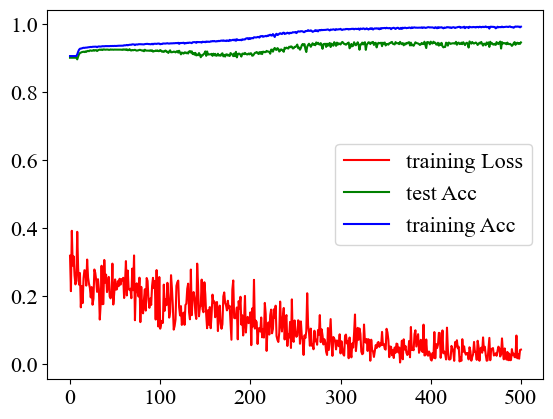

In [17]:
model2=train2(input,y_train,X_test,y_test,new_input,new_y_train)

ValueError: x and y must have same first dimension, but have shapes (0,) and (501,)

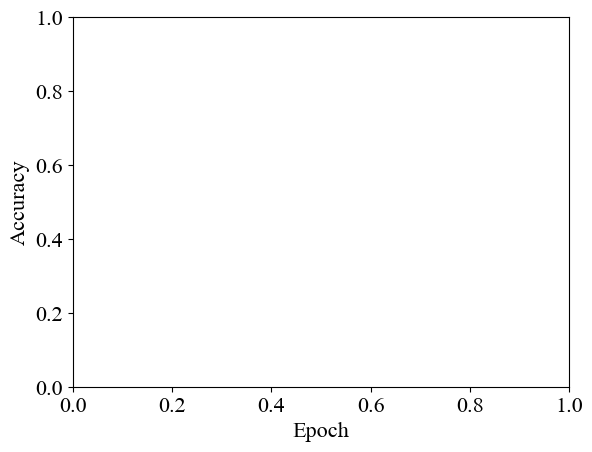

In [18]:
# plt.plot(epoch_list,loss_list,color='red',label='training Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.plot(epoch_list,ans_acc_list,color='red',label='CNN_TCN_BiLSTM_Attention')
plt.plot(epoch_list,ans_acc_list2,color='blue',label='CNN_TCN_BiGRU_Attention')
plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.plot(epoch_list,loss_list,color='red',label='CNN_TCN_BiLSTM_Attention')
plt.plot(epoch_list,loss_list2,color='blue',label='CNN_TCN_BiGRU_Attention')
# plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

In [ ]:
# import xlwt
# xl = xlwt.Workbook()
# # 调用对象的add_sheet方法
# sheet1 = xl.add_sheet('sheet1', cell_overwrite_ok=True)

# sheet1.write(0, 0, "cnn_tcn_bilstm_attention_accuracy")
# sheet1.write(0, 1, 'cnn_tcn_bilstm_attention_loss')


# for i in range(0, len(ans_acc_list)):
#     sheet1.write(i + 1, 0, ans_acc_list[i])
#     sheet1.write(i + 1, 1, loss_list[i])

# xl.save("csv/cnn_tcn_bilstm_attention.xlsx")

In [ ]:
import xlwt
xl = xlwt.Workbook()
# 调用对象的add_sheet方法
sheet1 = xl.add_sheet('sheet1', cell_overwrite_ok=True)

sheet1.write(0, 0, "cnn_tcn_bigru_attention_accuracy")
sheet1.write(0, 1, 'cnn_tcn_bigru_attention_loss')


for i in range(0, len(ans_acc_list2)):
    sheet1.write(i + 1, 0, ans_acc_list2[i])
    sheet1.write(i + 1, 1, loss_list2[i])

xl.save("csv/cnn_tcn_bigru_attention.xlsx")